<a href="https://colab.research.google.com/github/farkoo/Covid19-Detection-from-ChestXRayImages/blob/master/Covid19_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd drive/MyDrive

/content/drive/MyDrive


In [2]:
!git clone "https://github.com/farkoo/Covid19-Detection-from-ChestXRayImages.git"

Cloning into 'Covid19-Detection-from-ChestXRayImages'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 47 (delta 15), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (47/47), done.


In [4]:
%cd 'Covid19-Detection-from-ChestXRayImages'

/content/drive/My Drive/Covid19-Detection-from-ChestXRayImages


In [5]:
!7z x dataset.7z -odataset


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 12417162 bytes (12 MiB)

Extracting archive: dataset.7z
--
Path = dataset.7z
Type = 7z
Physical Size = 12417162
Headers Size = 1053
Method = LZMA:23
Solid = +
Blocks = 1

  0%     25% - dataset/covid/1.jpg                           42% 16 - dataset/covid/17.jpeg                                59% 20 - dataset/covid/21.jpeg                                92% 26 - dataset/normal/2.jpeg                                98% 48 - dataset/normal/18.jpeg

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import random

In [14]:
%cd dataset

/content/drive/My Drive/Covid19-Detection-from-ChestXRayImages/dataset/dataset


In [17]:
%cd ..

/content/drive/My Drive/Covid19-Detection-from-ChestXRayImages/dataset


In [26]:
# Hyper parameters
learning_rate = 1e-3
epochs = 25
batch_size = 8
dir = 'dataset'
width = 224
height = 224
classes = 2

In [27]:
def load_imgs_from_dir(dir, width, height):
  img_data = []
  img_label = []

  categories = os.listdir(dir)
  for category in categories:
    for file in os.listdir(os.path.join(dir,category)):
      img_path = os.path.join(dir,category,file)
      image = cv2.imread(img_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image,(width, height))
      img_data.append(image)
      img_label.append(category)
  img_data = np.asarray(img_data)
  img_label = np.asarray(img_label)
  zip_list = list(zip(img_data, img_label))
  random.shuffle(zip_list)
  img_data, img_label = zip(*zip_list)
  return img_data, img_label

In [28]:
data, label = load_imgs_from_dir(dir, width, height)

In [29]:
lb = LabelBinarizer()
one_hot = lb.fit_transform(label)
one_hot = to_categorical(one_hot)

In [30]:
train_X, test_X, train_Y, test_Y = train_test_split(data, one_hot, test_size = 0.10,
                                                    stratify = one_hot, random_state = 42)

In [31]:
train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size = 0.10,
                                                    stratify = train_Y, random_state = 13)

In [32]:
train_X = np.asarray(train_X)
test_X = np.asarray(test_X)
valid_X = np.asarray(valid_X)
valid_Y = np.asarray(valid_Y)
train_Y = np.asarray(train_Y)
test_Y = np.asarray(test_Y)

In [33]:
base_model = VGG16(weights = "imagenet", include_top = False,
                   input_tensor = Input(shape = (224, 224, 3)))

58892288/58889256 [==============================] - 0s 0us/step


In [34]:
head_model = base_model.output
head_model = AveragePooling2D(pool_size = (4, 4))(head_model)
head_model = Flatten(name = "flatten")(head_model)
head_model = Dense(64, activation = "relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation = "softmax")(head_model)

In [35]:
model = Model(inputs = base_model.input, outputs = head_model)

In [36]:
for layer in base_model.layers:
  layer.trainable = False

In [37]:
opt = Adam(learning_rate = learning_rate, decay = learning_rate/epochs)

In [38]:
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

In [39]:
H = model.fit(
    x = train_X,
    y = train_Y,
    steps_per_epoch = len(train_X)//batch_size,
    validation_data = (valid_X, valid_Y),
    validation_steps = len(valid_X)//batch_size,
    epochs = epochs
              )

Epoch 1/25
5/5 [==============================] - 32s 53ms/step - loss: 3.4919 - accuracy: 0.5250
Epoch 2/25
5/5 [==============================] - 0s 49ms/step - loss: 2.9466 - accuracy: 0.6250
Epoch 3/25
5/5 [==============================] - 0s 47ms/step - loss: 1.5844 - accuracy: 0.6250
Epoch 4/25
5/5 [==============================] - 0s 48ms/step - loss: 1.5972 - accuracy: 0.6750
Epoch 5/25
5/5 [==============================] - 0s 48ms/step - loss: 1.0106 - accuracy: 0.8750
Epoch 6/25
5/5 [==============================] - 0s 48ms/step - loss: 0.4193 - accuracy: 0.8750
Epoch 7/25
5/5 [==============================] - 0s 48ms/step - loss: 0.5952 - accuracy: 0.9500
Epoch 8/25
5/5 [==============================] - 0s 48ms/step - loss: 0.6369 - accuracy: 0.8750
Epoch 9/25
5/5 [==============================] - 0s 49ms/step - loss: 0.2422 - accuracy: 0.9500
Epoch 10/25
5/5 [==============================] - 0s 48ms/step - loss: 0.1695 - accuracy: 1.0000
Epoch 11/25
5/5 [===========

In [40]:
predIdxs = model.predict(test_X, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(test_Y.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       1.00      1.00      1.00         2
      normal       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



In [41]:
cm = confusion_matrix(test_Y.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


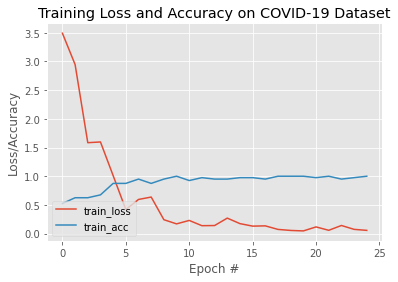

In [42]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [43]:
model.save('Covid19-model.h5')